<a href="https://colab.research.google.com/github/itchyfeet-patient/Beautiful-Exploration/blob/master/Exploration_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **16-13. 프로젝트 : Segmentation map으로 도로 이미지 만들기 🏡🚗**


## **Prologue**
이전 Pix2Pix 논문에서 제시한 결과 중에 아래와 같은 실험 결과가 있었습니다. 도로의 레이블 정보를 활용해 이미지를 생성해낸 결과입니다.

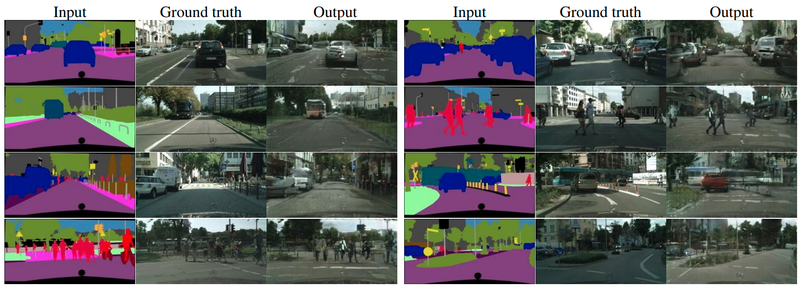

이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것입니다. 데이터셋은 아래에서 다운로드할 수 있습니다.
1000개의 학습용 이미지 및 5개의 평가 이미지를 포함합니다.

[cityscapes.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip)  

이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없습니다.
아래 Tensroflow에서 제공하는 Pix2Pix 튜토리얼은 위 이미지와 비슷한 레이블 정보 이미지를 사용하기 때문에 좋은 참고 자료가 될 수 있을 것 같습니다.

프로젝트 시작에 어려움이 있다면 아래 튜토리얼을 참고하시면서 이번 프로젝트를 수행해 봅시다.
(아래 튜토리얼은 Pix2Pix 구조를 Functional API를 이용해 구현하기 때문에 이번에 진행한 Subclassing 방법을 이용한 모델 구현과 비교하면서 구현 방법에 대해서도 공부해 보시길 추천드립니다)  

* [Tensorflow Pix2Pix Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)

프로젝트를 수행하기 전에 주요 라이브러리 버전을 살펴 봅시다.

In [102]:
import numpy
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt 

print(numpy.__version__)
print(tf.__version__)
# lms 1.21.4 / 2.6.0
# cv2 4.5.3

1.21.6
2.8.2


---

## **프로젝트 수행**
프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.  

1. 데이터에 한 가지 이상의 **augmentation 방법**을 적용하여 학습해 주세요.
(어떠한 방법을 사용했는지 적어주세요.)
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 **U-Net Generator**를 사용해 주세요.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 **스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화**해 주세요.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 **중간 손실 값에 대한 로그**를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

## (1) 데이터 준비하기 

In [103]:
# !cd /content/drive/MyDrive/dataset/conditional_generation/data/ && unzip cityscapes.zip

In [104]:
import os

data_path = '/content/drive/MyDrive/dataset/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


1000개의 데이터가 있습니다.

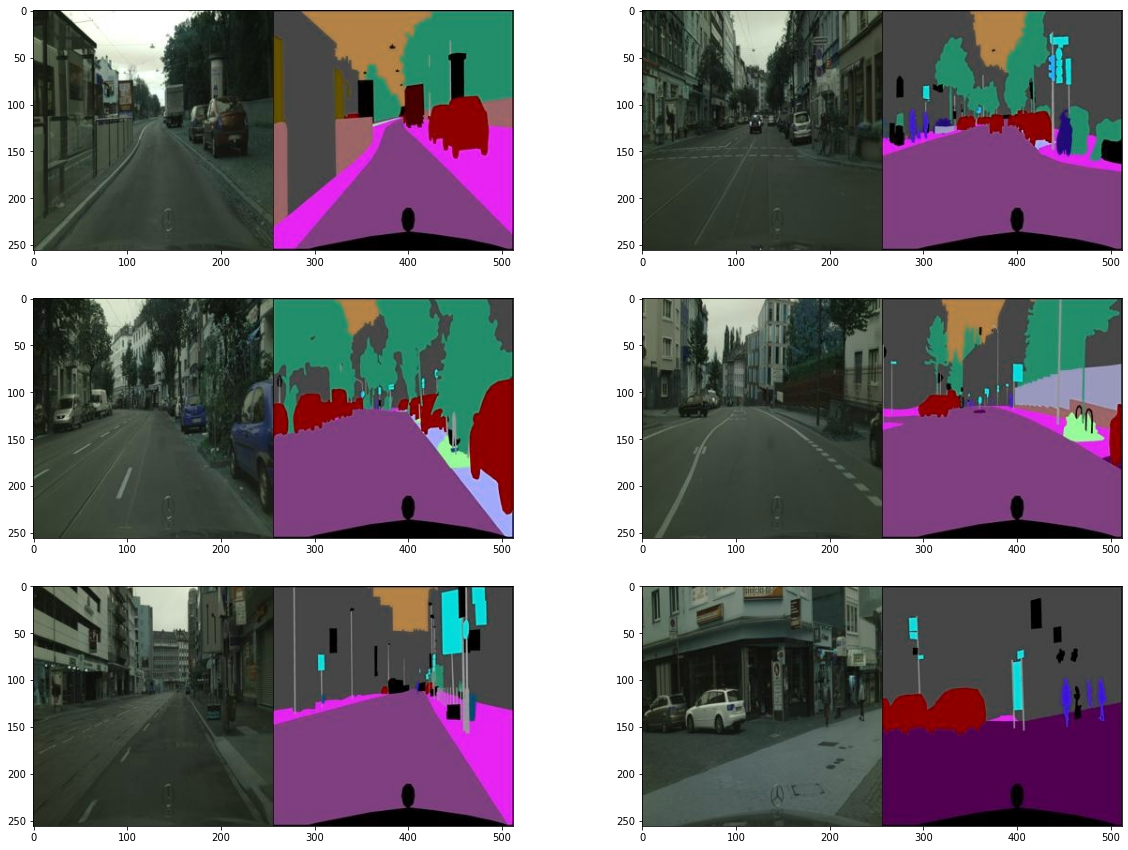

In [105]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [106]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


(256, 256, 3) 으로 분할해서 사용하면 되겠습니다.

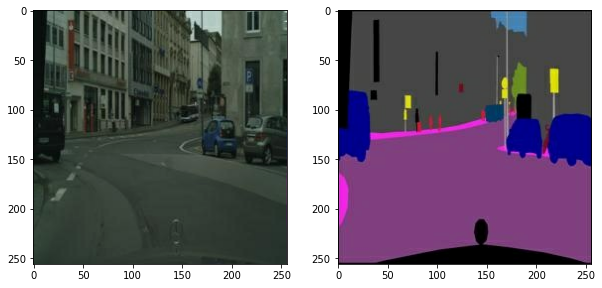

In [107]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    street = img[:, :w, :] # 반갈
    street = tf.cast(street, tf.float32)
    seg = img[:, w:, :] # 반갈
    seg = tf.cast(seg, tf.float32)
    return normalize(street), normalize(seg)

f = data_path + os.listdir(data_path)[1]
street, seg = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(street))
plt.subplot(1,2,2); plt.imshow(denormalize(seg))

잘 나눠졌습니다.

In [108]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.keras.preprocessing.image import random_brightness 

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(street, seg):
    

    stacked = tf.concat([street, seg], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    out = image.random_brightness(out, 0.5)
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
  

    return out[...,:3], out[...,3:]   

print("✅")

✅


Augmentation 방법~
1. 아까 나눈 사진 합침
2. 50% 확률로 refection 패딩 또는 constant 패딩
3. 256, 256, 6으로 랜덤으로 자르기
4. 50% 확률로 가로로 플립
5. 50% 확률로 세로로 플립
6. 50% 확률로 90도 회전
7. 50% 확률로 밝기 조절

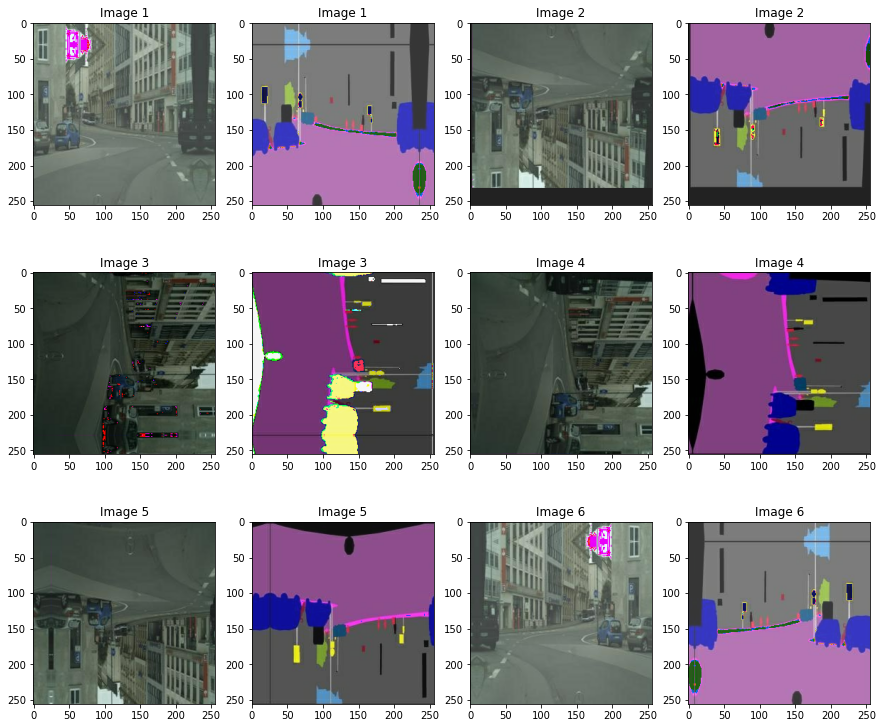

In [109]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_street, augmented_seg = apply_augmentation(street, seg)


    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_street)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1);
    plt.imshow(denormalize(augmented_seg)); plt.title(f"Image {img_n}")
    img_n += 1


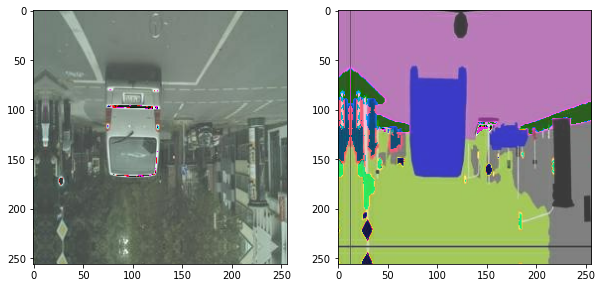

In [110]:
from tensorflow import data

def get_train(img_path):
    street, seg = load_img(img_path)
    street, seg = apply_augmentation(street, seg)
    return street, seg

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
street, seg = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(street[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(seg[0].astype(np.uint8))

적용시키고, 잘 적용됐는지 이미지 확인~

## (2) Generator 구성하기

In [111]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        # filter 크기 4 stride 2 고정
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [112]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        # filter 크기 4 stride 2 고정
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [113]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


filter 리스트에 각 블록을 거치면서 사용할 필터의 개수 저장  
block 리스트에 사용할 블록들 정의해서 추가. call 메서드에서 차례대로 블록 통과.

In [114]:
Encoder().get_summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 encode_block_64 (EncodeBloc  (None, 128, 128, 64)     3072      
 k)                                                              
                                                                 
 encode_block_65 (EncodeBloc  (None, 64, 64, 128)      131584    
 k)                                                              
                                                                 
 encode_block_66 (EncodeBloc  (None, 32, 32, 256)      525312    
 k)                                                              
                                                                 
 encode_block_67 (EncodeBloc  (None, 16, 16, 512)      2099200   
 k)                                                       

In [115]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [116]:
Decoder().get_summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1, 1, 512)]       0         
                                                                 
 decode_block_56 (DecodeBloc  (None, 2, 2, 512)        4196352   
 k)                                                              
                                                                 
 decode_block_57 (DecodeBloc  (None, 4, 4, 512)        4196352   
 k)                                                              
                                                                 
 decode_block_58 (DecodeBloc  (None, 8, 8, 512)        4196352   
 k)                                                              
                                                                 
 decode_block_59 (DecodeBloc  (None, 16, 16, 512)      4196352   
 k)                                                       

In [117]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 encoder_5 (Encoder)         (None, 1, 1, 512)         19544576  
                                                                 
 decoder_5 (Decoder)         (None, 256, 256, 3)       19542784  
                                                                 
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## (3) Generator 재구성하기


skip connection을 추가해서 더 좋은 구조인 u net을 사용한 generator로 재구성해보겠습니다.

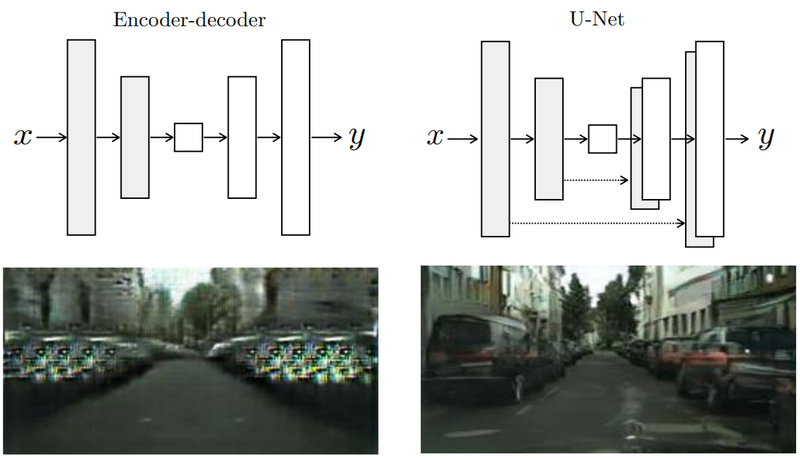

In [118]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [119]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = [] # 추가된 부분! encoder decoder skip connection을 위한 부분
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
            # feature에 encoder 내에서 사용된 출력들이 저장됨.
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
            # feature 리스트에 있는 각각의 출력들이 decoder 블록 연산 후 concat됨(다음 블록입력으로 사용)
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


위에서 추가된 부분은 features라는 리스트이고, encoder의 각각 블록들의 출력이 그때마다 저장됩니다.  
이 출력값들은 decoder의 입력으로 들어가게 됩니다.

In [120]:
UNetGenerator().get_summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_80 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_18[0][0]']               
                                )                                                                 
                                                                                                  
 encode_block_81 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_80[0][0]']        
                                                                                           

## (4) Discriminator 구성하기

In [121]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [122]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d_14 (ZeroPadd  (None, 130, 130, 32)     0         
 ing2D)                                                          
                                                                 
 conv2d_120 (Conv2D)         (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_185 (Ba  (None, 127, 127, 64)     256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_114 (LeakyReLU)  (None, 127, 127, 64)     0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainabl

In [123]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [124]:
Discriminator().get_summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_21 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_139 (Concatenate)  (None, 256, 256, 6)  0           ['input_20[0][0]',               
                                                                  'input_21[0][0]']        

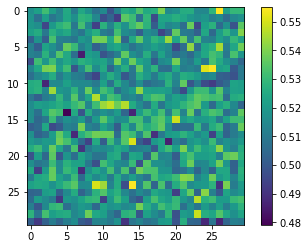

In [125]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

256,256,3 크기의 입력을 넣었을 때 나오는 출력 30,30 의 시각화입니다.

## (5) 학습 및 테스트하기

In [126]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


손실함수를 정의했습니다. generator의 손실함수, discriminator의 손실함수

In [127]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


adam optimizer를 사용합니다.

In [128]:
@tf.function
def train_step(street, real_seg):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_seg = generator(street, training=True)
        # Discriminator 예측
        fake_disc = discriminator(street, fake_seg, training=True)
        real_disc = discriminator(street, real_seg, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_seg, real_seg, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [ ]:
EPOCHS = 30
fig = plt.figure(figsize=(13,4))
g = []
l1 = []
d = []

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (street, seg) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(street, seg)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
    g.append(g_loss.numpy())
    l1.append(l1_loss.numpy())
    d.append(d_loss.numpy())

epochs = range(1, len(g)+1)

ax1 = fig.add_subplot(1,3,1)
plt.plot(epochs, g, 'r', label='Generator loss')
plt.title('Generator loss')
plt.xlabel('Epochs')
plt.ylabel('g_Loss')
plt.legend()

ax2 = fig.add_subplot(1,3,2)
plt.plot(epochs, l1, 'y', label='L1 loss')
plt.title('L1 loss')
plt.xlabel('Epochs')
plt.ylabel('L1_Loss')
plt.legend()

ax3 = fig.add_subplot(1,3,3)
plt.plot(epochs, d, 'b', label='Discriminator loss')
plt.title('Discriminator loss')
plt.xlabel('Epochs')
plt.ylabel('d_Loss')
plt.legend()

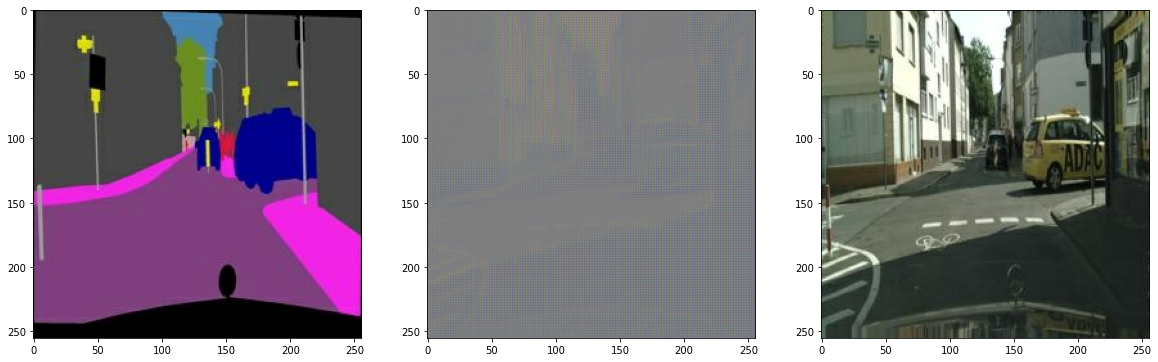

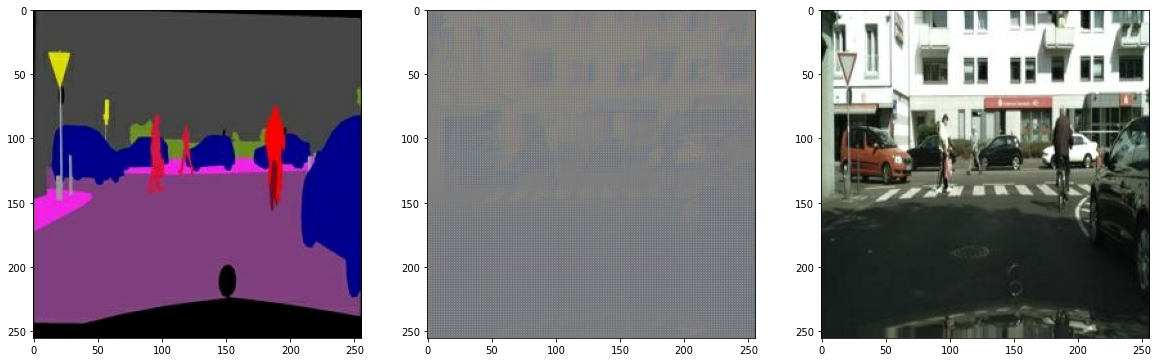

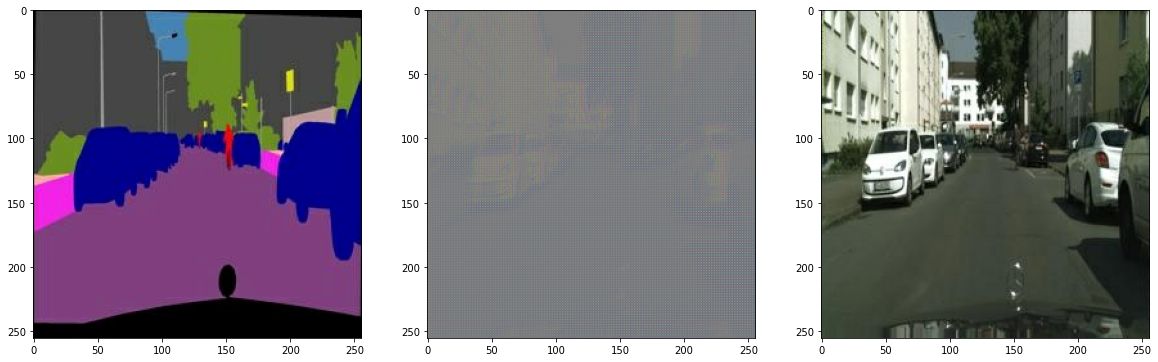

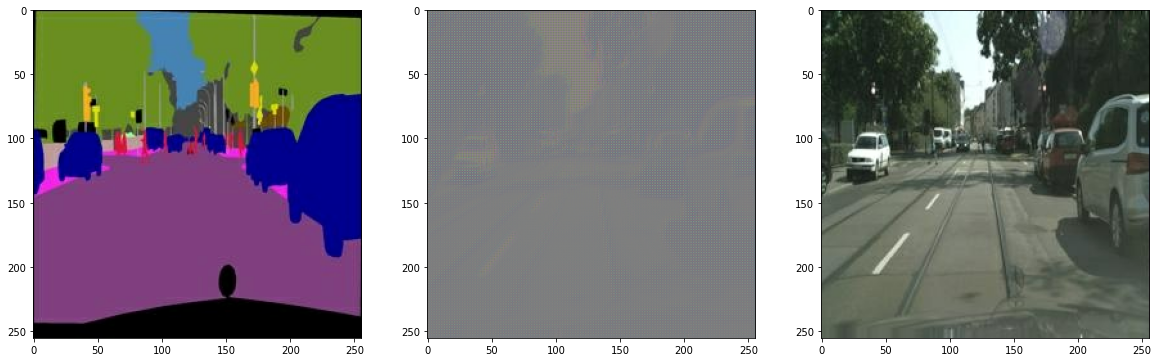

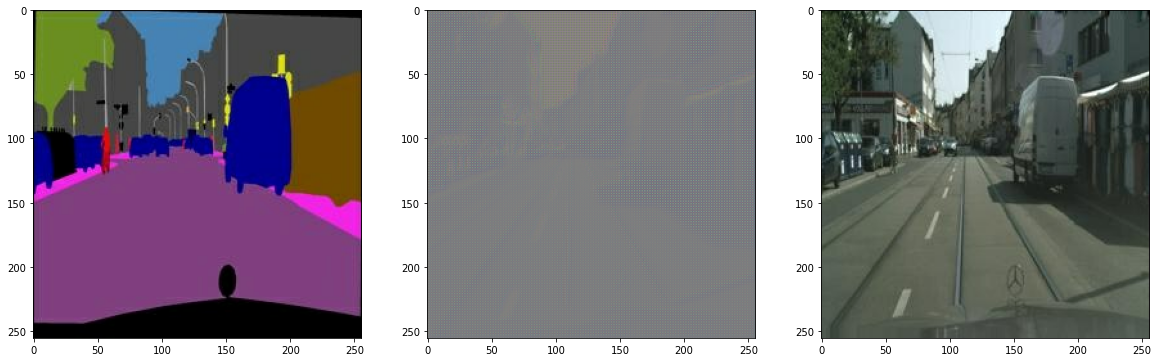

In [132]:
test_path = '/content/drive/MyDrive/dataset/conditional_generation/data/cityscapes/val/'

for i in range(len(os.listdir(test_path))):
    f = test_path + os.listdir(test_path)[i]
    street, seg = load_img(f)

    pred = generator(tf.expand_dims(street, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(seg))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(street))

### lms에서 주어진 augmentation, epoch = 100

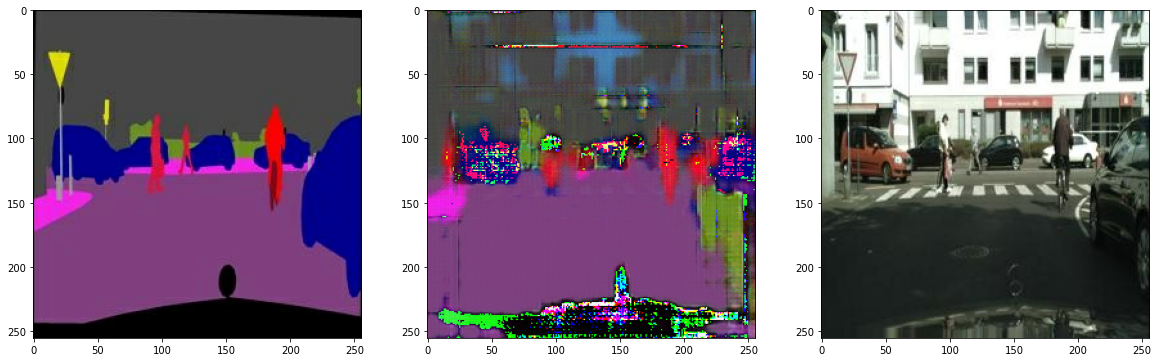

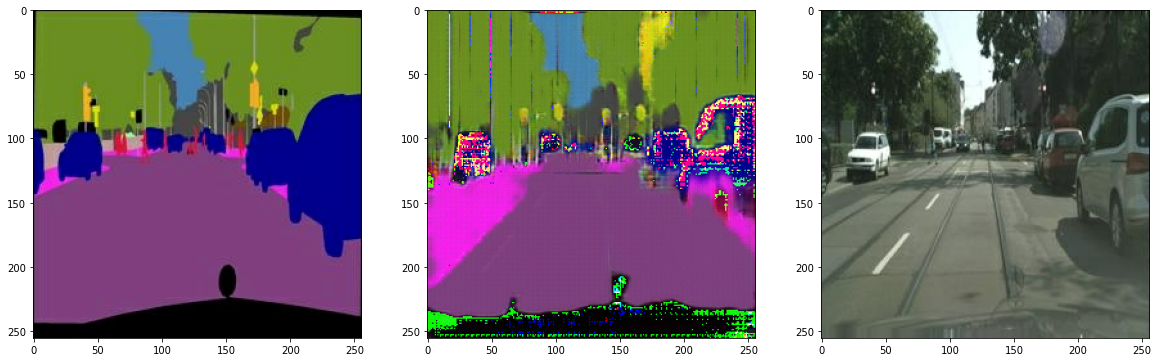

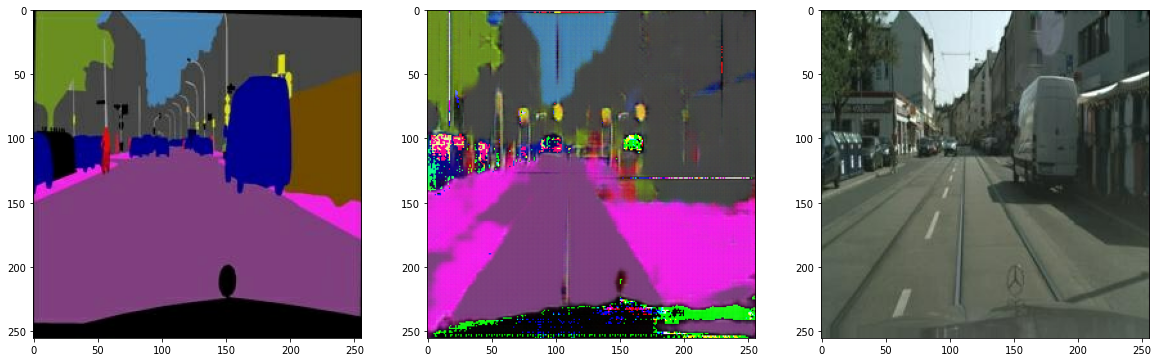

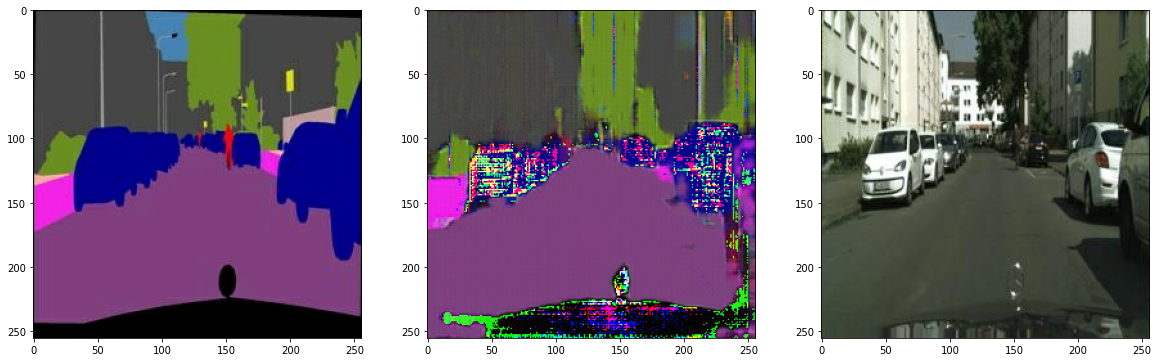

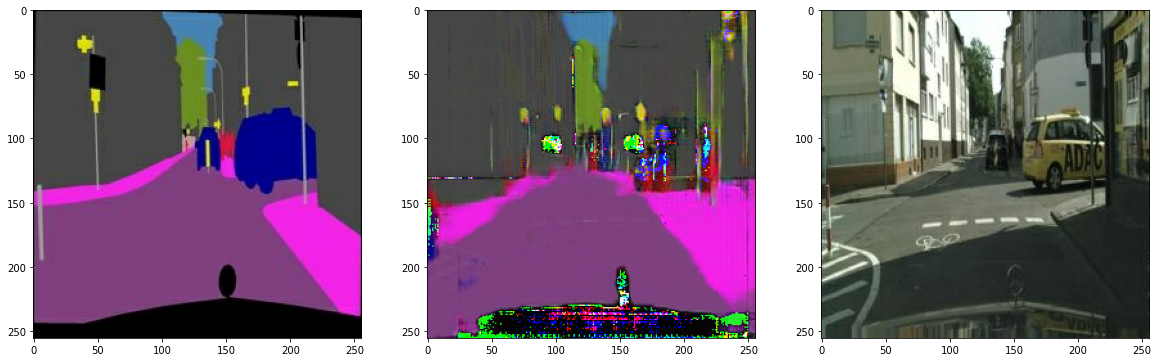

### + random_brightness 추가 / epoch 30

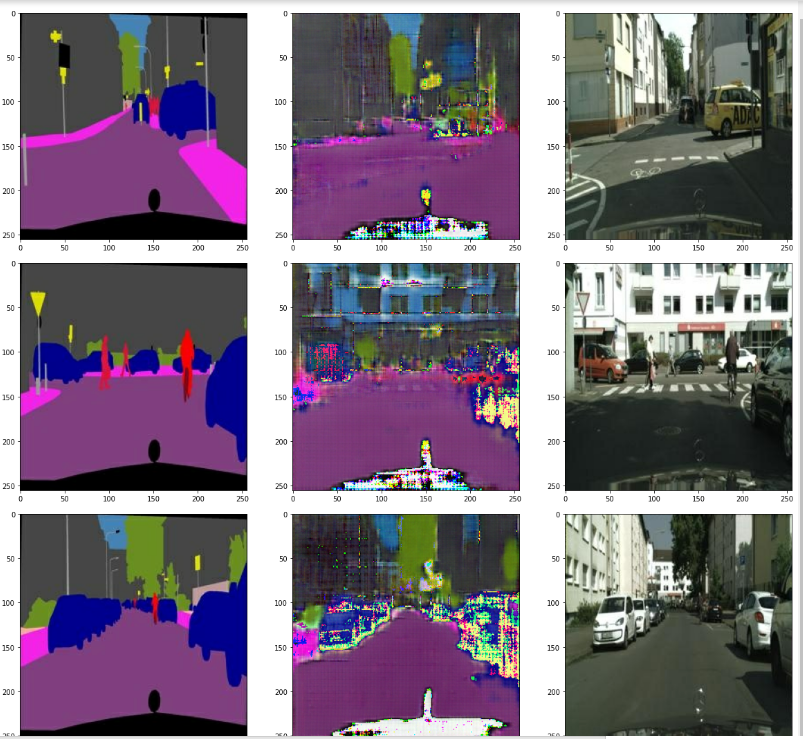

---

## 🌮 루브릭
| **평가문항** | **상세기준** | **성취결과** |
|:---:|---|:---:|
| 1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다. | 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한  데이터셋 구축 과정이 체계적으로 제시되었다. | O |
| 2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다. | U-Net generator, discriminator 모델 구현이 완료되어  train_step의 output을 확인하고 개선하였다. | O |
| 3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다. | 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서  진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다. | O |

## ✍ 회고

* DCGAN 이후에 GAN을 처음 써본건데 조건을 추가할 수 있다는 점이 인상깊었다. DCGAN 실습 당시 내가 원하는 결과가 무작위로 나왔고 generator와 discriminator가 싸울때 기도하고 있을 수밖에 없었다.


* DCGAN 에서는 epoch를 높이면 높일수록 결과가 선명해졌는데 CGAN에서는 오히려 더 흐려지고 품질이 좋지 않았다.

* augmentation을 더 다양하게 하고자 시도해봤으나 salt noise 방법이 잘 안됐다. numpy 변환에 문제가 있었던 듯 싶은데 아쉬웠다. 대신 tensorflow의 다른 메서드를 사용했다. 그 과정에서 사용되지 않는 메서드도 있었다. 버전 차이였던듯?

* loss가 적게 나온다고 무조건 좋은 학습이 아니었다. loss 진폭이 커서 학습결과가 안좋은건가?

* 그리고 조금만 학습을 많이하거나 심기를 거스르면 뿌연 이미지를 출력했다. 가장 처음학습에서 10epoch을 돌렸는데 나만 저런 이미지가 나왔다. 알쏭달쏭 CV

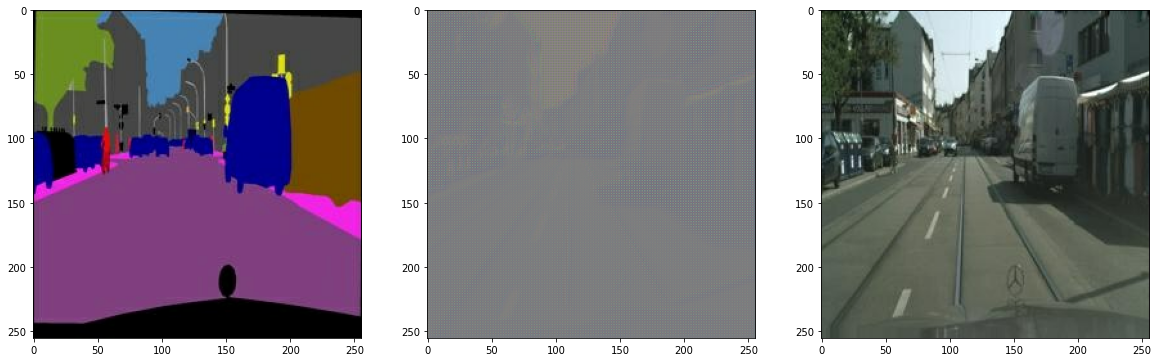

### 📚 참고문헌


[loss graph](https://github.com/hyunnie94/AIFFEL/blob/master/E20_conditionalGAN/%5BE20%5D%20Pix2Pix%20GAN.ipynb)